In [1]:
using Distributions,StatsBase,PythonPlot,DataFrames,Optim,NLsolve
PythonPlot.svg(true)
FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

include("simulations.jl")
include("models.jl")

runar (generic function with 1 method)

# Generate population tree 

In [3]:
# plotting functions
function recursive_draw_tree(ax,node,x0,y0,depth,h,lw)
    val = 0. #max(0.2,min(abs(node.label/(τ*D)),1))
    clr = (val,val,val)
    dt = (node.label[2])*h
    ax.plot([x0,x0],[y0,y0-dt],"-",c=clr,lw=lw)
    
    if node.left != nothing

        val =  0#max(0.2,min(abs(node.right.label/(τ*D)),1))
        clr = (val,val,val)
        ax.plot([x0,x0+2.0^(-depth)],[y0-dt,y0-dt],"-",c=clr,lw=lw)
        recursive_draw_tree(ax,node.left,x0-2.0^(-depth),y0-dt,depth+1,h,lw)

        val =  0#max(0.2,min(abs(node.left.label/(τ*D)),1))
        clr = (val,val,val)
        ax.plot([x0-2.0^(-depth),x0],[y0-dt,y0-dt],"-",c=clr,lw=lw)
        recursive_draw_tree(ax,node.right,x0+2.0^(-depth),y0-dt,depth+1,h,lw)
    end
end


function recursive_draw_lineage(ax,node,x0,y0,depth,h,lw,clr)

    dt = node.label[2]*h
    ax.plot([x0,x0],[y0,y0-dt],"-",c=clr,lw=lw)
    
    if node.left != nothing
        r = rand()
        if r <0.5
            ax.plot([x0,x0+2.0^(-depth)],[y0-dt,y0-dt],"-",c=clr,lw=lw)
            return recursive_draw_lineage(ax,node.right,x0+2.0^(-depth),y0-dt,depth+1,h,lw,clr)
        else
            ax.plot([x0-2.0^(-depth),x0],[y0-dt,y0-dt],"-",c=clr,lw=lw)
            return recursive_draw_lineage(ax,node.left,x0-2.0^(-depth),y0-dt,depth+1,h,lw,clr)
        end        
    end
    return x0,y0-dt,depth
end

recursive_draw_lineage (generic function with 1 method)

In [4]:
θ = (a=0.2,σ = 0.1)

init = [0.0,1.0]
Tmax = 6
function terminate(cell)
    cell.label[1]>Tmax
end


root = create_cell(init)
# 

# # trim the tree
# for node in get_leaf_nodes(root)
#     node.label[1] = Tmax
# end
grow_tree!(root,terminate,θ,AR1)



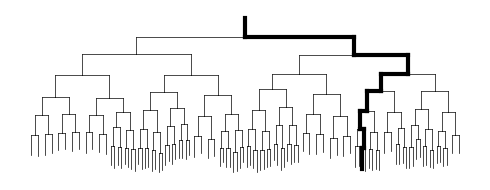

In [5]:

fig,ax = subplots(figsize=(5,2))

x0,y0,depth,h,lw = 0,0,0,1,0.5
recursive_draw_tree(ax,root,x0,y0,depth,h,lw)


ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.spines["bottom"].set_visible(false)
ax.spines["left"].set_visible(false)
tick_params(left = false, right = false , labelleft = false,labelbottom = false, bottom = false) 

tight_layout()

lw = 3
x,y,depth = recursive_draw_lineage(ax,root,x0,y0,0,h,lw,"k")

savefig(FIG_PATH*"/intro_tree.pdf")
fig

# Generate simulated lineages

TODO: Rewrite this code to be integrated into existing framework for simulations

In [28]:

θ = (σM=0.2,σλ = 0.1)

function generate_adder_lineage(θ,n)
    M = zeros(n+1)

    M[1] = 1
    for k in 2:(n+1)
        M[k] = (M[k-1]  + 1)/2 + rand(Normal(0,θ.σM))/2
    end
    G = rand(Normal(1,θ.σλ),n+1)
    T = log.(2M[2:end] ./ (M[1:end-1])) ./G[1:end-1]
    return DataFrame(hcat(M[1:end-1],G[1:end-1],T,cumsum(T)),[:M,:λ,:τ,:t])
end

dfs = [generate_adder_lineage(θ,200) for j in 1:200];
dfs


200-element Vector{DataFrame}:
 200×4 DataFrame
 Row │ M         λ         τ         t         
     │ Float64   Float64   Float64   Float64   
─────┼─────────────────────────────────────────
   1 │ 1.0       0.979779  0.87844     0.87844
   2 │ 1.18238   0.84566   0.718403    1.59684
   3 │ 1.08536   0.957505  0.7615      2.35834
   4 │ 1.12513   0.955546  0.707115    3.06546
   5 │ 1.10565   1.1183    0.554087    3.61955
   6 │ 1.02729   0.982991  0.762487    4.38203
   7 │ 1.08686   1.06226   0.553703    4.93573
   8 │ 0.978553  0.989943  0.757596    5.69333
  ⋮  │    ⋮         ⋮         ⋮          ⋮
 194 │ 0.99036   1.03556   0.538501  134.805
 195 │ 0.864864  1.00574   0.968666  135.773
 196 │ 1.14556   0.937146  0.75142   136.525
 197 │ 1.15828   1.27358   0.561701  137.087
 198 │ 1.18431   0.748047  0.945325  138.032
 199 │ 1.20101   1.05473   0.553805  138.586
 200 │ 1.07694   0.960689  0.573612  139.159
                               185 rows omitted
 200×4 DataFrame
 Row │ M 

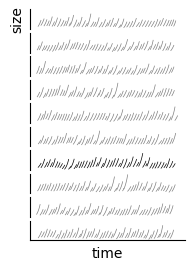

In [29]:

nrows = 10
fig,axs = subplots(figsize=(2,3),nrows=nrows,sharex=true,sharey=true)
for k in 1:nrows
    ax = axs[k-1]
    df = dfs[k][1:50,:]
    for i in 1:(length(df.M)-1)
        trng = collect(df.t[i]:0.01:df.t[i+1]) 
        #ax.vlines([df.t[i+1]],df.M[i+1],exp.(df.τ[i] *df.λ[i])*df.M[i],color="k",lw=0.4,linestyle="--")
        ax.plot(trng,df.M[i] .* exp.((trng .- trng[1]) .* df.λ[i]),"-",lw=0.5,color= (k == 7) ? "k" : "gray")
    end
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    ax.spines["bottom"].set_visible(false)
    ax.tick_params(bottom = false) 
    ax.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false) 
    # ax.vlines([34],0,3,color="C4")    
    # ax.vlines([df[46,:t]],0,3,color="C1") 
    
end
axs[0].set_ylabel("size")
axs[length(axs)-1].spines["bottom"].set_visible(true)
axs[length(axs)-1].set_xlabel("time")


savefig(FIG_PATH*"/intro_lineages.pdf",bbox_inches="tight")

fig

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


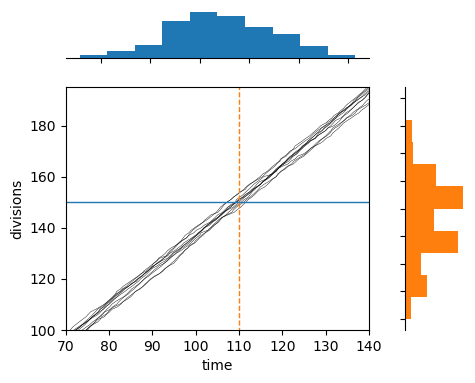

In [27]:
fig = figure(figsize=(5, 4))
gs = fig.add_gridspec(2, 2,  width_ratios=(10, 2), height_ratios=(2, 10),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.2)
                    
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

# -------------------------------------------------------
for k in 1:10
    df = dfs[k]
    ax.plot(df.t,(1:length(df.t)),"k-",markersize=0.1,lw=0.3)
end
ax.vlines([110],0,200,linestyle="--",color="C1",lw=1)
ax.plot(dfs[1].t,150ones(length(dfs[1].t)),"C0-",lw=1)
xlims = [70,140]
ylims = [100,195]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# -------------------------------------------------------
ax_histx.tick_params(axis="both", left=false, top=false, right=false, bottom=true, labelleft=false, labeltop=false, labelright=false, labelbottom=false,labelsize=8)     
ax_histy.tick_params(axis="both", left=true, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false,labelsize=8)
ax_histx.spines["right"].set_visible(false)
ax_histx.spines["top"].set_visible(false)
ax_histx.spines["left"].set_visible(false)
ax_histy.spines["right"].set_visible(false)
ax_histy.spines["top"].set_visible(false)
ax_histy.spines["bottom"].set_visible(false)

#bins = collect(100:1:200)
h,x = ax_histx.hist([df.t[150] for df in dfs],10,color="C0",density=true)
#ax_histx.set_xlim([100,110])
#x = (bins[1:end-1] .+ bins[2:end]) ./2
#ax_histx.plot(x,h,"C5-")


ax_histy.hist([length(df[df.t .< 110,:].t) for df in dfs],10,color="C1",orientation="horizontal",density=true)
#ax_histy.set_ylim([150,165])
ax.set_xlabel("time")
ax.set_ylabel("divisions")

tight_layout()

savefig(FIG_PATH*"/intro_hist.pdf",bbox_inches="tight")
fig

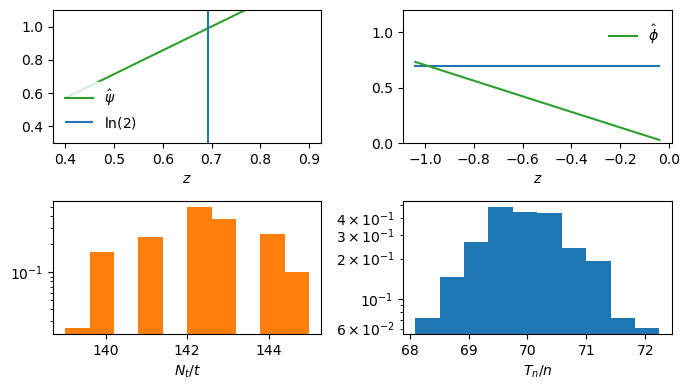

In [243]:
fig,axs= subplots(figsize=(7,4),nrows = 2,ncols=2)

# ----------------------------------------------------------------------
# FTE
ax = axs[1,0]
t = 100
# division counts
N = [length(df[df.t .< t,:].t) for df in dfs] 
ax.hist(N,10,color="C1",density=true)
ax.semilogy()
ax.set_xlabel(L"$N_t/t$")

ax = axs[0,0]
psi = z -> log(mean(exp.(N[1:2] .* z)))/t
psi_hat = z -> log(mean(exp.(N .* z)))/t
z_range = collect(0.4:0.1:1.3*log(2))
#ax.plot(z_range,psi.(z_range),"C1")
ax.plot(z_range,psi_hat.(z_range),"C2-",label=L"$\hat{\psi}$")
#ax.set_ylabel(L"$\psi$")
ax.set_xlabel(L"$z$")
#ax.plot(z_range,-z_range,"k--")
ax.vlines(log(2),-8,8,label=L"$\ln(2)$")
ax.set_ylim([0.3,1.1])
tight_layout()
ax.legend(loc=3,facecolor="white",framealpha=0.8,fancybox=false,edgecolor="w")


# ----------------------------------------------------------------------
# FDE
ax = axs[1,1]
n = 100
# division counts
T = [df.t[n] for df in dfs] 
ax.hist(T,10,color="C0",density=true)
ax.semilogy()
ax.set_xlabel(L"$T_n/n$")


ax = axs[0,1]
phi = z -> log(mean(exp.(-T[1:2] .* z)))/t
phi_hat = z -> log(mean(exp.(-T .* z)))/t
z_range = collect(-1.5*log(2):0.1:0)
ax.plot(z_range,ones(length(z_range)) .* log(2))
#ax.plot(z_range,phi.(z_range),"C1")
ax.plot(z_range,phi_hat.(z_range),"C2-",label=L"$\hat{\phi}$")
#ax.set_ylabel(L"$\phi$")
ax.set_xlabel(L"$z$")
ax.set_ylim([0,1.2])

tight_layout()
ax.legend(frameon=false)

savefig(FIG_PATH*"/intro_hist2.pdf",bbox_inches="tight")
fig